In [ ]:
# pretrained word embeddings 
### Hossein Yousefi 

In [9]:
#Downloading the IMDB data from http://mng.bz/0tIo
import os

imdb_dir = '/home/hossein/Downloads/wordembedding/aclImdb' # <=== Replace your dic 
train_dir = os.path.join(imdb_dir , 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [15]:
#Tokenizing and vectorizing the data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels=np.asarray(labels)
print('shape of data tensor :', data.shape)
print('shape of label tensor :', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

found 88582 unique tokens.
shape of data tensor : (25000, 100)
shape of label tensor : (25000,)


In [19]:
# Download from  https://nlp.stanford.edu/projects/glove/
glove_dir = '/home/hossein/Downloads/wordembedding/glove.6B' # <=== Replace your dic
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs 
    f.closed

In [20]:
embedding_dim = 100 

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [23]:
#traninig 
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 1.9133 - acc: 0.5150 - val_loss: 0.6918 - val_acc: 0.5402
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.6362 - acc: 0.6650 - val_loss: 0.7924 - val_acc: 0.5224
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3214 - acc: 0.8700 - val_loss: 1.5138 - val_acc: 0.5047
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4858 - acc: 0.8500 - val_loss: 0.9057 - val_acc: 0.5300
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1740 - acc: 0.9550 - val_loss: 0.8333 - val_acc: 0.5307
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0705 - acc: 1.0000 - val_loss: 0.7664 - val_acc: 0.5670
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2936 - acc: 0.8950 - val_loss: 0.7857 - val_acc: 0.5507
Epoch 8/10
200/200 [========

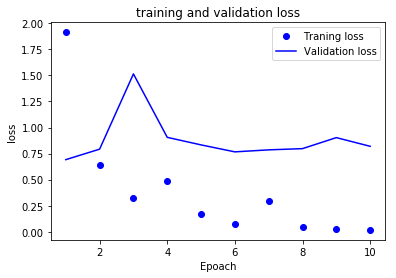

In [25]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs,loss_values, 'bo', label='Traning loss')
plt.plot(epochs,val_loss_values, 'b', label='Validation loss')
plt.title('training and validation loss')
plt.xlabel('Epoach')
plt.ylabel('loss')
plt.legend()
plt.show()


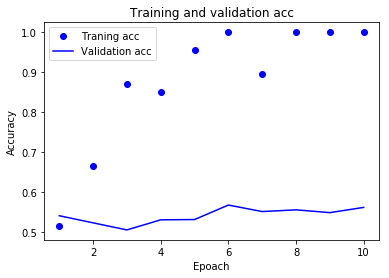

In [26]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs,acc_values, 'bo', label='Traning acc')
plt.plot(epochs,val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epoach')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [28]:
#Evaluation on the test data 
test_dir = os.path.join(imdb_dir, 'test')

labels =[]
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 3s 108us/step


[0.8014758405303956, 0.57724]